## Intro

* Metropolis 是 Markov Chain Monte Carlo, MCMC 的一种。
  * MCMC的定义：构造一个Markov Chain，其平稳分布是你想采样(Sample)的分布。
  * 随机过程、Markov Chain、平稳分布的定义：我习题课会讲
* 直观理解：把你想采样的分布想象成山峰，往山上走，一定会接受新点，往山下走，有时会接受新点。（凡用此思想的方法都可称之为Metropolis，就像用随机数的方法都可称之为Monte Carlo一样）
* 严格的数学证明：可以证明Metropolis的结果的确是$Cf(x)$, $C$是归一化常数，$f(x)$是你想采样的分布或者你想求解的积分。Below I will give a rough proof:
  * Let $\pi(x)$ be the distribution you want to sample.
  * Let $Q(y|x)$ be the proposal distribution. It represents the probability density (in continuous spaces) or probability (in discrete spaces) of proposing a new state $y$ given the current state $x$.
    * In our random walk method, $Q(x| y) = Q(y| x)$.
    * But now let us consider a more general case.
  * So $P(y|x) = Q(y|x) A(y|x) = Q(y|x) min(1,\frac{\pi(y)Q(x|y)}{\pi(x)Q(y|x)})$ (提出提案并且提案通过)
    * $A(y|x)$ is the probability of accept $y$ after selecting $y$ from $x$.
    * $A(y|x) :=  min(1,\frac{\pi(y)Q(x|y)}{\pi(x)Q(y|x)})$, it is designed as this to make sure $\pi(x)$ is the steady distribution of this Markov Chain.
  * So, $\pi(x) P(y|x) =\pi(x) Q(y|x) min(1,\frac{\pi(y)Q(x|y)}{\pi(x)Q(y|x)}) = min(\pi(x) Q(y|x),\pi(y)Q(x|y))$
  * By symmetry, $\pi(y) P(x|y) = min(\pi(y) Q(x|y),\pi(x)Q(y|x))$
  * Finally, $\pi(x) P(y|x) = \pi(y) P(x|y)$. Can you understand what this equation means?
* 如何得到归一化常数？
  * 答：见后文HW3下的三种做法。
* Python, MATLAB, MMA会用Metropolis计算形如$\int_{0}^{10} x^2 sin(x) e^{-x} dx$的复杂积分吗？
  * 答：不会。
  * 他们会用确定性(Deterministic)的方法，比如Simpson's rule, Gauss-Kronrod, Adaptive Quadrature。Metropolis在低维积分上比不过这些方法。
* 那为什么要用MC？
  * 答：因为它在处理高维情况时特别好用。
  * 高维欧几里得空间中，MC计算积分会超越Gauss-Kronrod等方法，见`Why_Monte_Carlo_in_High_Dim.ipynb`。
* 那又为什么要用Metropolis？
  * 答：因为它在处理高维情况时比普通MC还好用。
  * 高维欧几里得空间有些诡异的性质，比如球的体积大多在超球的表面，比如任取两个向量其夹角大概率在85°-95°之间，这些性质导致直接用np.random抽样不好。因为：
    * 大多数样本会集中在球壳附近，而我们希望探索整个球体。
    * 向量彼此几乎正交，使得探索复杂分布时出现大量空隙，难以有效覆盖整个空间。
  * MCMC（如Metropolis-Hastings）通过逐步构建链式采样，有效探索分布的高概率区域，避免了在高维空间中出现大量空隙的情况。
* Python有库函数内置Metropolis吗？（From GPT-4o, may be wrong）
  * 答：有。
  * PyMC：专注于贝叶斯建模。它支持多种MCMC算法，其中包括Metropolis-Hastings。
  * emcee：特别适合天文学、物理学等领域的贝叶斯推断问题。它实现了一种特殊的Metropolis类算法，称为Affine Invariant Ensemble Sampler。
  * TensorFlow Probability (TFP) ：TensorFlow生态系统的一部分，用于概率建模和推断。它实现了多种MCMC算法，包括Metropolis-Hastings。适合深度学习与概率推断结合的场景，如变分推断或贝叶斯神经网络。
  * Stan ：一个强大的概率编程语言和库，专注于贝叶斯模型的推断。虽然Stan更依赖于NUTS等自适应MCMC方法，但它也支持Metropolis-Hastings。
* 我在哪里能学到更多？
  * 答：周志华《机器学习》14.5.1；李航《统计学习方法》第19章。
  * 以 Metropolis 为首的MCMC是统计和机器学习的重要内容。
* Rosetta（2024诺奖）是如何是用Metropolis求解蛋白质结构的？
  * 答：定义一个评估蛋白质构象的稳定性的能量函数（考虑氨基酸相互作用、疏水效应等因素），随机改变构象（比如改变某个键角或者某个二面角），并用Metropolis准则（P = exp(-ΔE/kT）)决定是否接受新的构象。
  * 这样定义的P保证了该算法会在能量低的地方采更多样，并且有能力跳出局部极小。
  * 它和模拟退火算法(Simulated Annealing)有些类似，但并不完全一样。模拟退火还引入了逐渐降低温度的过程（为了使系统在初期能跳出局部极小），因此多了一层循环。”
* 一些历史：Metropolis-Hastings 算 法 是 由 N. Metropolis等人 1953 年 提 出 [Metropolis et aL, 1 9 5 3 ],此后 W. K. Hastings将其推广到一般形 式 [Hastings, 1 9 7 0 ],因此而得名.

## An Example

### Deterministic Method

下面，我将展示一个用Metropolis和Importance Sampling计算积分的例子。

试求 $\int_{0}^{10} x^2 sin(x) e^{-x} dx$

In [1]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the function to integrate
def integrand(x):
    return x**2 * np.sin(x) * np.exp(-x)

# Perform the integration
result, error = integrate.quad(integrand, 0, 10)

# Print the result
print(f"The result of the integration is: {result}")
print(f"The error bound is: {error}")

The result of the integration is: 0.5035272509544617
The error bound is: 1.4965318674198883e-14


scipy的integrate算出的理论值如上，它用的是确定性的方法，此处可能是adaptive Gauss-Kronrod quadrature。

### Stochastic Method

接下来我们尝试普通MC，分层抽样MC，Metropolis。

In [3]:
from Monte_Carlo import monte_carlo_integration, stratified_sampling, importance_sampling

我们把之前写好的函数放到 `.py` 文件里，而后import。

In [4]:
# Function to integrate
def f(x):
    return x**2 *np.sin(x) * np.exp(-x)

定义要积分的函数

In [32]:
# Integration parameters
a, b = 0, 10
n_samples = 10 ** 5

# True value for comparison (analytically calculated)
result, error = integrate.quad(integrand, 0, 10)  # Redefine result
true_value = result  # Approximate value of the integral

# Basic Monte Carlo Integration
mc_estimate, mc_error = monte_carlo_integration(f, a, b, n_samples, true_value)
print(f"Monte Carlo estimate: {mc_estimate}, Absolute error: {mc_error}")

# Stratified Sampling Integration
stratified_estimate, stratified_error = stratified_sampling(f, a, b, n_samples, strata=10, true_value=true_value)
print(f"Stratified Sampling estimate: {stratified_estimate}, Absolute error: {stratified_error}")

Monte Carlo estimate: 0.512767686099612, Absolute error: 0.009240435145150272
Stratified Sampling estimate: 0.501247412415173, Absolute error: 0.0022798385392887033


看起来效果很不错嘛，当然分层抽样依然比普通MC好。

In [33]:
# Importance Sampling using g(x) = e^(-x)
importance_dist = {
    'sample': lambda n: np.random.exponential(1, n) / (np.exp(-a) - np.exp(-b)),  # Sampling from Exponential(1)
    'pdf': lambda x: np.exp(-x) / (np.exp(-a) - np.exp(-b))  # PDF of Exponential(1) is e^(-x)
}

# Importance Sampling Integration
importance_estimate, importance_error = importance_sampling(f, a, b, n_samples, true_value, importance_dist)
print(f"Importance Sampling estimate: {importance_estimate}, Absolute error: {importance_error}")

Importance Sampling estimate: 0.49764757321853204, Absolute error: 0.005879677735929678


重要性采样效果似乎不错.不如更换N,画图试试?

接下来试试把重要性采样中的库函数换成我们自己的Metropolis

In [34]:
from Monte_Carlo import metropolis_sampling_with_pbc

In [35]:
# Target distribution g(x) = e^(-x), proportional to the exponential distribution PDF
def g(x):
    return np.exp(-x) / (np.exp(-a) - np.exp(-b))

In [36]:
# Use the Metropolis algorithm to sample from g(x)
metropolis_samples, acceptance_rate = metropolis_sampling_with_pbc(n_samples, g, a, b)
print(f"Acceptance rate: {acceptance_rate:.4f}")

# Calculate the integral using importance sampling with weights f(x)/g(x) = x^2 sin(x)
weights = metropolis_samples ** 2 * np.sin(metropolis_samples)
integral_estimate = np.mean(weights)
print(f"Estimated integral using Metropolis sampling: {integral_estimate}")
print(f"Absolute error: {np.abs(integral_estimate - true_value)}")

Acceptance rate: 0.6977
Estimated integral using Metropolis sampling: 0.5604152563164435
Absolute error: 0.0568880053619818


还是没能比得过普通MC

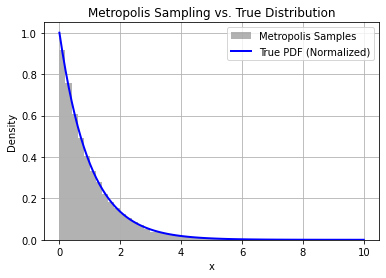

In [37]:
# Display some information about the samples
x = np.linspace(a, b, 100)
plt.hist(metropolis_samples, bins=50, density=True, alpha=0.6, color='gray', label='Metropolis Samples')
plt.plot(x, np.exp(-x) / (np.exp(-a) - np.exp(-b)), label='True PDF (Normalized)', linewidth=2, color='blue')
plt.title('Metropolis Sampling vs. True Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

分布和$e^{-x}$看上去是很像的。同学们也可以去查查，除了画出来表示两个分布长得像，是否有一些定量指标描述两个分布之间的相似程度或“距离”。

## HW 3

试求 $\int_{0}^{4} x^{2} e^{-x} dx$

Feed-back:

大家好。HW3我们已经批完。一个常见错误是用Metropolis得到正确的分布后，直接用

```python
integral = (b - a) * np.mean([f(xi) for xi in samples])
```

去计算积分值。这样会得到1.7~1.8之间的结果。错误。

正确方法是有三种，设$f(x) = x^2 e^{-x}$

1. 用Metropolis采样后，分bin，每个bin计算$f(x)$
2. 用Metropolis采样后，分bin，每个bin计算$f(x)/Metropolis(x)$
3. 用Metropolis对 $g(x) = e^{-x}$ 采样，计算$f(x)/g(x)$

除了第三种，剩下两种的计算量显然是多于普通的黎曼积分的。第三种也只有在高维积分时候才能比得过黎曼积分。

### Deterministic Method

In [38]:
# Define the function to integrate
def integrand(x):
    return x ** (2) * np.exp(-x)

# upper and lower limits of integration
a, b = 0, 4 # 100 is large enough for the exponential to be close to zero

# Perform the integration
result, error = integrate.quad(integrand, a, b)

# Print the result
print(f"The result of the integration is: {result:.4f}")
print(f"The error bound is: {error:.4f}")

The result of the integration is: 1.5238
The error bound is: 0.0000


### Stochastic Method

In [39]:
from Monte_Carlo import monte_carlo_integration, stratified_sampling, importance_sampling

In [40]:
# True value for comparison (analytically calculated)
result, error = integrate.quad(integrand, a, b)  # Redefine result
true_value = result  # Approximate value of the integral

In [42]:
# Importance Sampling using g(x) = e^(-x)
# importance_dist = {
#     'sample': lambda n: np.random.exponential(1, n),
#     'pdf': lambda x: np.exp(-x)
# }

# # Importance Sampling using g(x) = e^(-x) for x in [0, 4]
# importance_dist = {
#     'sample': lambda n: np.random.exponential(1, n) / (1 - np.exp(-4)),  #
#     'pdf': lambda x: np.exp(-x) / (1 - np.exp(-4))  # PDF
# }

# Importance Sampling using g(x) = (3/64) * x^2
importance_dist = {
    'sample': lambda n: 4 * np.random.rand(n)**(1/3),  # Inverse CDF sampling
    'pdf': lambda x: (3 / 64) * x**2  # PDF proportional to 3/64 * x^2
}


In [81]:
# Function to integrate
def f(x):
    return x ** (2) * np.exp(-x)

#
n_samples = 10 ** 4

# Basic Monte Carlo Integration
mc_estimate, mc_error = monte_carlo_integration(f, a, b, n_samples, true_value)
print(f"Monte Carlo estimate: {mc_estimate}, Absolute error: {mc_error}")

# Stratified Sampling Integration
stratified_estimate, stratified_error = stratified_sampling(f, a, b, n_samples, strata = 10, true_value = true_value)
print(f"Stratified Sampling estimate: {stratified_estimate}, Absolute error: {stratified_error}")

# Importance Sampling Integration
importance_estimate, importance_error = importance_sampling(f, a, b, n_samples, true_value, importance_dist)
print(f"Importance Sampling estimate: {importance_estimate}, Absolute error: {importance_error}")

Monte Carlo estimate: 1.5250395679875768, Absolute error: 0.0012461790946656226
Stratified Sampling estimate: 1.5228966305322023, Absolute error: 0.0008967583607089047
Importance Sampling estimate: 1.5168720715554573, Absolute error: 0.006921317337453825


### Compare

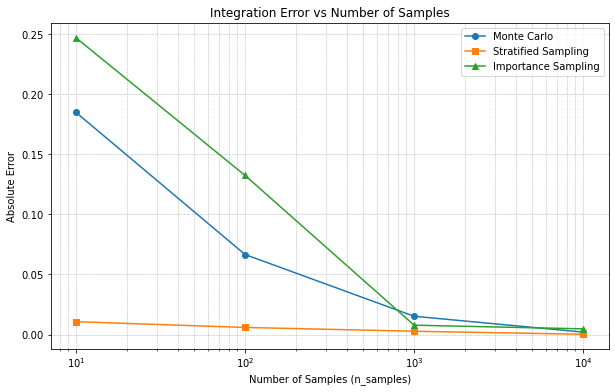

In [90]:
# Define different numbers of samples to test
n_samples_list = [10, 100, 1000, 10000]

# Lists to store absolute errors for each method
mc_errors = []
stratified_errors = []
importance_errors = []

#
use_seed = False

# Run integrations for each sample size
for n_samples in n_samples_list:
    # Basic Monte Carlo Integration
    mc_estimate, mc_error = monte_carlo_integration(f, a, b, n_samples, true_value, use_seed)
    mc_errors.append(mc_error)
    
    # Stratified Sampling Integration
    strat_estimate, strat_error = stratified_sampling(f, a, b, n_samples, strata = 10, true_value = true_value, use_seed = use_seed)
    stratified_errors.append(strat_error)
    
    # Importance Sampling Integration
    imp_estimate, imp_error = importance_sampling(f, a, b, n_samples, true_value, importance_dist, use_seed)
    importance_errors.append(imp_error)

# Create a semilogarithmic plot for absolute errors
plt.figure(figsize=(10, 6))

plt.semilogx(n_samples_list, mc_errors, 'o-', label='Monte Carlo')
plt.semilogx(n_samples_list, stratified_errors, 's-', label='Stratified Sampling')
plt.semilogx(n_samples_list, importance_errors, '^-', label='Importance Sampling')

plt.xlabel('Number of Samples (n_samples)')
plt.ylabel('Absolute Error')
plt.title('Integration Error vs Number of Samples')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

当我没有设置`seed`的时候，每次run都会得到不同的图，咋办？

In [113]:
from Monte_Carlo import compare

# Define different numbers of samples to test
n_samples_list = np.logspace(2, 5, num=20, base=10, dtype=int)

# Number of experiments to run for each sample size
n_exp = 100  # Adjust as needed

mc_mean, stratified_mean, importance_mean, mc_se, stratified_se, importance_se = compare(n_samples_list, n_exp, f, a, b, true_value, importance_dist)

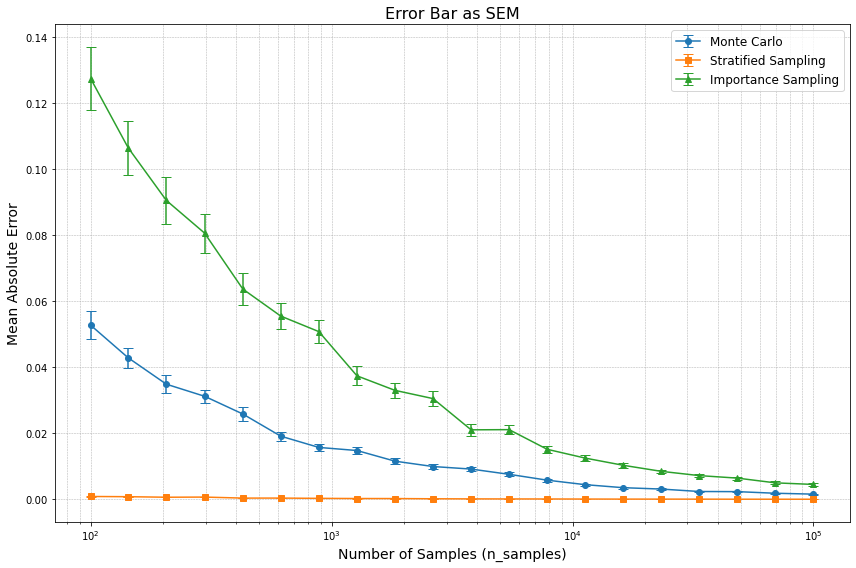

In [114]:
# Create a semilogarithmic plot for absolute errors with error bars
plt.figure(figsize=(12, 8))

# Plot Mean Absolute Errors with Error Bars
plt.errorbar(n_samples_list, mc_mean, yerr=mc_se, fmt='o-', label='Monte Carlo', capsize=5)
plt.errorbar(n_samples_list, stratified_mean, yerr=stratified_se, fmt='s-', label='Stratified Sampling', capsize=5)
plt.errorbar(n_samples_list, importance_mean, yerr=importance_se, fmt='^-', label='Importance Sampling', capsize=5)

# Set x-axis to logarithmic scale
plt.xscale('log')

# Labels and Title
plt.xlabel('Number of Samples (n_samples)', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Bar as SEM', fontsize=16)

# Legend
plt.legend(fontsize=12)

# Grid for better readability
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

诶，看上去很不错！！！

如果我们把y轴也改成对数尺度会怎么样？

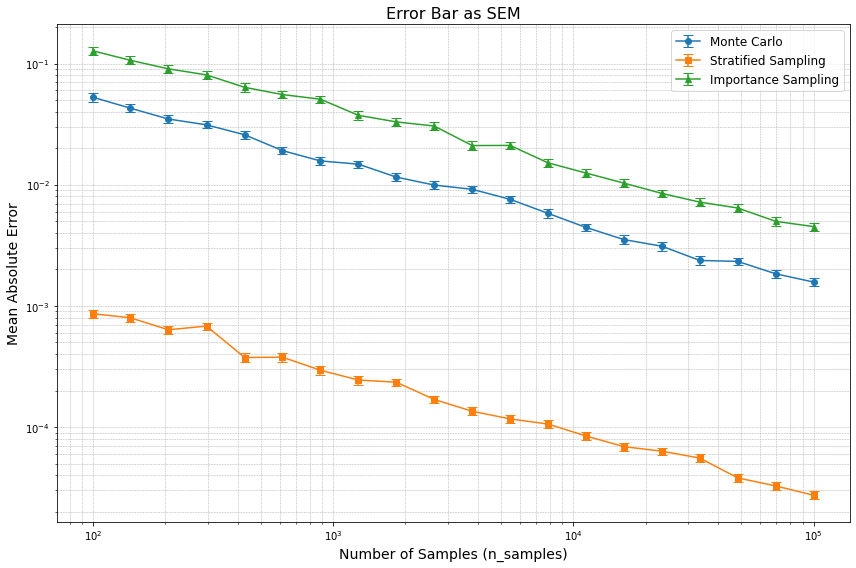

In [115]:
# Create a semilogarithmic plot for absolute errors with error bars
plt.figure(figsize=(12, 8))

# Plot Mean Absolute Errors with Error Bars
plt.errorbar(n_samples_list, mc_mean, yerr=mc_se, fmt='o-', label='Monte Carlo', capsize=5)
plt.errorbar(n_samples_list, stratified_mean, yerr=stratified_se, fmt='s-', label='Stratified Sampling', capsize=5)
plt.errorbar(n_samples_list, importance_mean, yerr=importance_se, fmt='^-', label='Importance Sampling', capsize=5)

# Set x-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Labels and Title
plt.xlabel('Number of Samples (n_samples)', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Bar as SEM', fontsize=16)

# Legend
plt.legend(fontsize=12)

# Grid for better readability
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

哈，看来y和x的关系是$y = \frac{1}{x^n}$。$n = \frac{1}{2}$。

另外，分层抽样中，分的层越多，效果越好。

理论值也应是$\frac{1}{2}$，因为

$$
X_1, X_2, ..., X_n \ i.i.d. \Rightarrow Var(\bar{X}) = \frac{Var(X_i)}{n} \Rightarrow Std(\bar{X}) = \frac{Std(X_i)}{\sqrt{n}} 
$$ 

如果我们把x轴和y轴都改成普通尺度会怎么样？

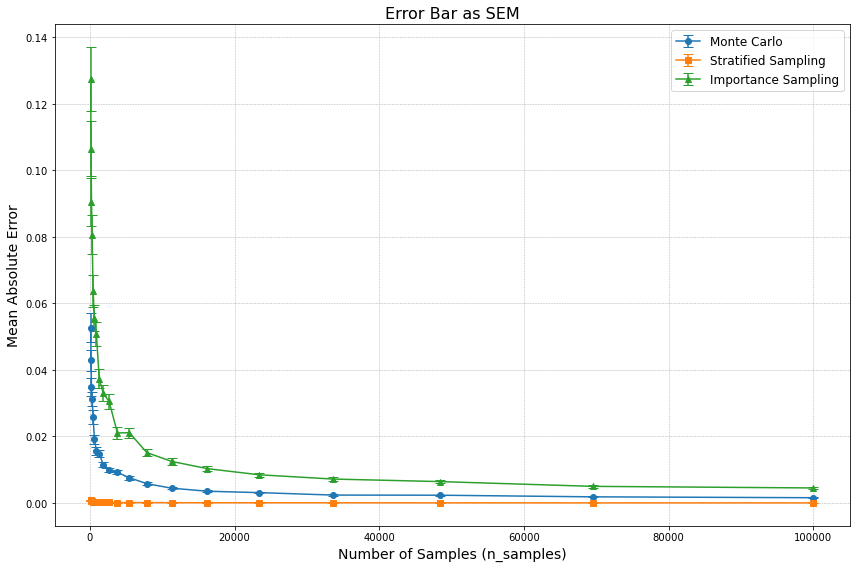

In [116]:
# Create a semilogarithmic plot for absolute errors with error bars
plt.figure(figsize=(12, 8))

# Plot Mean Absolute Errors with Error Bars
plt.errorbar(n_samples_list, mc_mean, yerr=mc_se, fmt='o-', label='Monte Carlo', capsize=5)
plt.errorbar(n_samples_list, stratified_mean, yerr=stratified_se, fmt='s-', label='Stratified Sampling', capsize=5)
plt.errorbar(n_samples_list, importance_mean, yerr=importance_se, fmt='^-', label='Importance Sampling', capsize=5)

# Set back
plt.xscale('linear')
plt.yscale('linear')

# Labels and Title
plt.xlabel('Number of Samples (n_samples)', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Bar as SEM', fontsize=16)

# Legend
plt.legend(fontsize=12)

# Grid for better readability
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

很好，什么也看不出来。所以以后记得在对数尺度上画图找找灵感。一共无非四种
1. linear, linear
2. linear, log
3. log, linear
4. log, log

# Direct MC vs Metropolis

Suppose we want to sample from $f(x) \sim e^{- x^4 + x^2}$

When we want to calculate $\int_0^2 f(x) dx$, direct MC is useful, but when we want to sample from this $f(x)$, direct MC is not feasible.

In [117]:
# Define the unnormalized density function
def unnormalized_posterior(x):
    return np.exp(-x**4 + x**2)

# Attempt to sample directly (this will fail)
# There is no built-in function to sample from this distribution
try:
    samples = np.random.some_distribution(size=10000)  # Placeholder
except AttributeError:
    print("Direct sampling is not feasible for this distribution.")

Direct sampling is not feasible for this distribution.


Acceptance rate: 0.6500


Text(0.5, 1.0, 'Metropolis Samples')

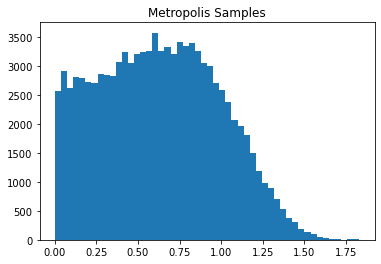

In [118]:
# Number of samples
n_samples = 10 ** 5

# Use the Metropolis algorithm to sample from g(x)
a = 0
b = 4
metropolis_samples, acceptance_rate = metropolis_sampling_with_pbc(n_samples, unnormalized_posterior, a, b)
print(f"Acceptance rate: {acceptance_rate:.4f}")

# plot hist
plt.hist(metropolis_samples, bins=50)
plt.title('Metropolis Samples')

# Metropolis vs Gibbs (Optional)

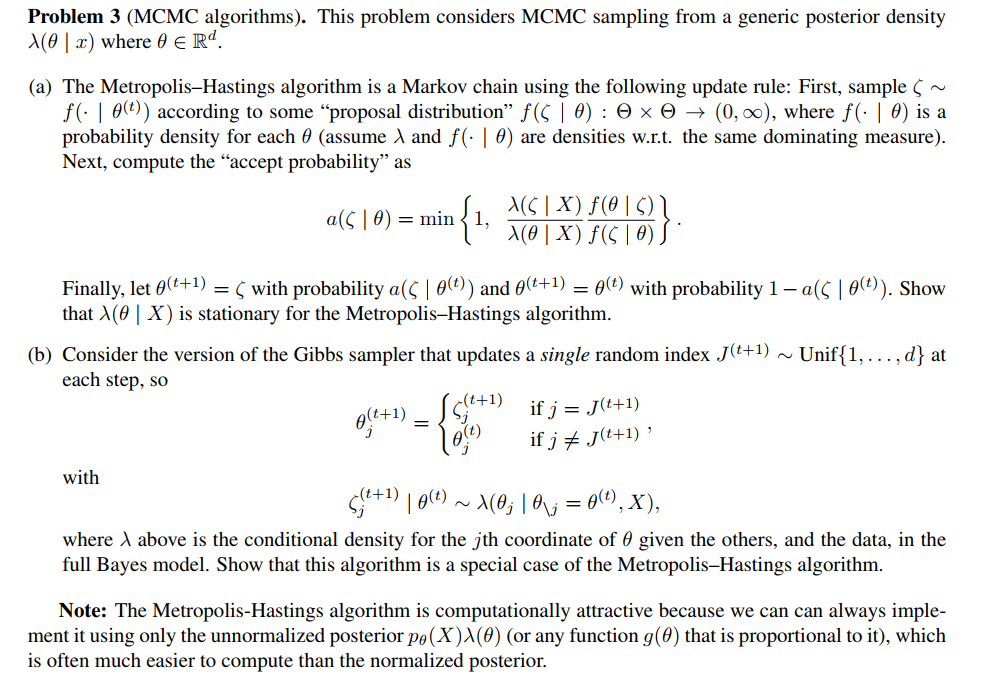

# Summary

总结一下本次习题课：
1. Monte Carlo
   1. Direct Monte Carlo就是初中学的简单随机抽样，Stratified Monte Carlo就是高中学的分层抽样。
   2. Why Use Monte Carlo in High Dim?: 因为它在高维中相比那些决定性(Deterministic)方法有优势
      1. Memory is independent of `n_dim`.
      2. Time is independent of `n_dim`.
      3. Error is independent of `n_dim`.
   3. Why Variance of Monte Carlo Is Important?: 因为Monte Carlo的Bias是0。
2. Stochastic Process
   1. Definition: $X(w,t)$, where w represents trials and t represents time.
   2. Def of Markov Chain: $P(X_{t+1}|X_t,X_{t-1},...,X_{1}) = P(X_{t+1}|X_t)$.
   3. Def of the Steady Distribution of a Markov Chain: $\forall x, y \ \ \pi(x) P(y|x) = \pi(y) P(x|y)$
3. Markov Chain Monte Carlo
   1. MCMC的定义：构造一个Markov Chain，其平稳分布是你想采样(Sample)的分布。
   2. Why Metropolis?
      1. 在采样上：Direct Monte Carlo不能采样复杂分布（尽管可以算其定积分，即曲线下面积），而Metropolis可以。
      2. 在积分计算上：在高维空间，Metropolis可以更好地探索整个空间，而Direct Monte Carlo会留下空隙。
4. For Figures
   1. 画图要加Error-Bar，别只画Mean。
      1. Error Bar表示的是结果的不确定性，避免误导读者以为绘制的均值完全可靠。
      2. Error-Bar用$Standard \ Deviation$或$Standard \ Deviation/\sqrt{N}$是需要思考的。
         1. 当你想展示$X_i$的不确定性，用前者
         2. 当你想展示$\bar{X}$的不确定性，用后者
         3. 比如，你想展示你找的人类被试的年龄分布就用前者，你想展示此文件中平均误差的可靠程度就用后者。
   2. 记得试试对数尺度做图。
      1. 在数据量级跨度较大时，对数尺度可以更好地展现趋势。
      2. 当y和x是指数关系或者多项式关系时，对数尺度可以发现普通坐标系下看不出的趋势。
5. Programming
   1. Function: Wrap your codes up into a function, whenever you want to re-use.
   2. Class: Wrap up many functions into a class, whenever their goals and inputs are similar.
   3. Vectorization: Try to use vectorization, whenever you want to use for loop.
   4. Anonymous Function: Try to use anonymous function, when you want to write your func in one line.